\# Developer: Ali Hashaam (ali.hashaam@initos.com) <br>
\# 27th January 2019 <br>

\# © 2019 initOS GmbH <br>
\# License MIT <br>

In [2]:
from __future__ import division
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
import pandas as pd
import numpy as np
import re, random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.metrics import accuracy_score

/home/ali/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
regex_square_brackets = re.compile(r'(\[)|(\])')

In [33]:
bugs = pd.read_csv('../datasets/lexical_semantic_preprocessed_mantis_bugs_less_columns_with_class_expansion.csv')
bug_notes = pd.read_csv('../datasets/lexical_semantic_preprocessed_mantis_bugnotes.csv')

In [34]:
bug_notes['bug_note'] = bug_notes['bug_note'].str.replace(regex_square_brackets, '')
bugs['additional_information'] = bugs['additional_information'].str.replace(regex_square_brackets, '')
bugs['description'] = bugs['description'].str.replace(regex_square_brackets, '')
bugs['summary'] = bugs['summary'].str.replace(regex_square_brackets, '')
df_bug_note_table = bug_notes.groupby(['bug_id'])['bug_note'].apply(','.join).to_frame('bug_notes').reset_index()
result = pd.merge(bugs, df_bug_note_table, how='left', left_on='id', right_on='bug_id')
result['textual_data'] = result['summary'].fillna('') + ',' + result['description'].fillna('') + ',' + result['additional_information'].fillna('') + ',' + result['bug_notes'].fillna('')

In [35]:
result['textual_data'] = result['textual_data'].str.replace(" ", "")
result.sort_values(by=['class'], inplace=True)
result.reset_index(drop=True, inplace= True)

In [36]:
result.loc[result['class']=='critical', 'class'] = 0
result.loc[result['class']=='non-critical', 'class'] = 1
unlabelled_index = result[(result['class'].isnull())].index
labelled_index = result[~(result['class'].isnull())].index
print result['class'].value_counts()

1    2591
0    1104
Name: class, dtype: int64


# Label Spreading and Propogation

In [37]:
def text_based_classification(df, classifier, classifier_name, label_type):
    for no_of_features in [100, 500, 1000]:
        print("""####################### Running for Number of features {} ############################""".format(no_of_features))
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_of_features, stop_words='english')
        X = tfidf_vectorizer.fit_transform(df['textual_data']).toarray()
        Y = np.array(df['class'])
        #print("members for classes {}".format(",".join("(%s,%s)" % tup for tup in sorted(Counter(Y).items()))))
        X_U = X[unlabelled_index]
        X_l = X[labelled_index]
        Y_l = Y[labelled_index]
        stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=0)
        scores = []
        iteration = 1
        for train_index, test_index in stratified_shuffle_split.split(X_l, Y_l):
            #X_train = X_l[train_index].copy()
            #Y_train = Y_l[train_index].copy()
            X_test = X_l[test_index].copy()
            Y_test = Y_l[test_index].copy()
            X_l_u = np.vstack((X_l, X_U))
            Y_U = np.full((X_U.shape[0], ), -1)
            if label_type == 'int':
                Y_l_u = np.concatenate((Y_l, Y_U))
            else:
                Y_l_u = np.concatenate((Y_l, Y_U)).astype(float)
            classifier.fit(X_l_u, Y_l_u)
            joblib.dump(classifier, 'models/{}_{}_{}.pkl'.format(classifier_name, no_of_features, iteration))
            joblib.dump(X_l, 'models/X_test_{}_{}_{}.pkl'.format(classifier_name, no_of_features, iteration))
            joblib.dump(Y_l, 'models/Y_test_{}_{}_{}.pkl'.format(classifier_name, no_of_features, iteration))
            #score = classifier.score(X_test, Y_test.astype(float))
            #scores.append(score)
            iteration += 1
        #print "{} average score: {}".format(classifier_name, np.mean(scores))
    return classifier

In [24]:
start_time = time.time()
ls = text_based_classification(result, LabelPropagation(n_jobs=-1), 'LabelPropogation', 'float')
print("--- %s seconds ---" % (time.time() - start_time))

####################### Running for Number of features 100 ############################
####################### Running for Number of features 500 ############################
####################### Running for Number of features 1000 ############################
--- 873.825999975 seconds ---


In [13]:
#it took 347 seconds to execute label propogatoion
#it took 25.9317 seconds to execute label spreading

In [25]:
model = joblib.load('models/{}_{}_{}.pkl'.format("LabelPropogation", 500, 3))
x = joblib.load('models/X_test_{}_{}_{}.pkl'.format("LabelPropogation", 500, 3))
y = joblib.load('models/Y_test_{}_{}_{}.pkl'.format("LabelPropogation", 500, 3))

In [29]:
accuracy_score(y_tst.astype(data_type), model.transduction_[:2217].astype(data_type))

members for classes (0,662),(1,1555)


In [30]:
result = classification_report(y.astype(float), model.transduction_[:2217].astype(float), output_dict=True)

In [38]:
start_time = time.time()
label_spreading = text_based_classification(result, LabelSpreading(n_jobs=-1), 'LabelSpreading', 'float')
print("--- %s seconds ---" % (time.time() - start_time))

####################### Running for Number of features 100 ############################
####################### Running for Number of features 500 ############################
####################### Running for Number of features 1000 ############################
--- 169.430999994 seconds ---


In [72]:
def get_results(classifier, data_type):
    dict_features = {}
    dict_acc = {}
    for features in [500]:
        model = joblib.load('models/{}_{}_{}.pkl'.format(classifier, features, 3))
        x_tst = joblib.load('models/X_test_{}_{}_{}.pkl'.format(classifier, features, 3))
        y_tst = joblib.load('models/Y_test_{}_{}_{}.pkl'.format(classifier, features, 3))
        acc = accuracy_score(y_tst.astype(data_type), model.transduction_[:2217].astype(data_type))
        result = classification_report(y_tst.astype(data_type), model.transduction_[:2217].astype(data_type), output_dict=True)
        dict_features[str(features)] = pd.DataFrame(result)
        dict_features[str(features)].transpose().to_csv('{}_{}_latex_table_report.csv'.format(classifier, features))
        dict_acc[str(features)] = acc
    print(dict_features[str(500)])
    arrays = [["Precision", "Precision", "Precision", "Recall", "Recall", "Recall", "F1-score", "F1-score", 
               "F1-score"], ['Critical', 'Non-Critical', 'Weighted Avg.', 'Critical', 'Non-Critical', 
                                       'Weighted Avg.', 'Critical', 'Non-Critical', 'Weighted Avg.']]
    MI = pd.MultiIndex.from_arrays(arrays, names=('Measures', 'Classes'))
    vals = [[round(dict_features[str(features)].loc['precision', '0.0'], 2)],
             [round(dict_features[str(features)].loc['precision', '1.0'], 2)],
             [round(dict_features[str(features)].loc['precision', 'weighted avg'], 2)],
             [round(dict_features[str(features)].loc['recall', '0.0'], 2)],
             [round(dict_features[str(features)].loc['recall', '1.0'], 2)],
             [round(dict_features[str(features)].loc['recall', 'weighted avg'], 2)],
             [round(dict_features[str(features)].loc['f1-score', '0.0'], 2)],
             [round(dict_features[str(features)].loc['f1-score', '1.0'], 2)],
             [round(dict_features[str(features)].loc['f1-score', 'weighted avg'], 2)]]
             #[round(dict_acc[str(features)],2)]]
    df = pd.DataFrame(vals, index=MI, columns=['vals'])  
    df = df.unstack().transpose().reset_index(level=0, drop=True)
    ax = df.plot(kind='bar', figsize=(8,6), rot=False)
    
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='upper left')
    plt.xlabel('Evaluation Measure {}'.format(classifier), fontsize=12)
    plt.savefig('{}_results.pdf'.format(classifier), dpi=720)
    return df

/home/ali/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


                  0.0          1.0  accuracy    macro avg  weighted avg
precision    0.310142     0.708546  0.556157     0.509344      0.589582
recall       0.397281     0.623794  0.556157     0.510538      0.556157
f1-score     0.348344     0.663475  0.556157     0.505910      0.569376
support    662.000000  1555.000000  0.556157  2217.000000   2217.000000


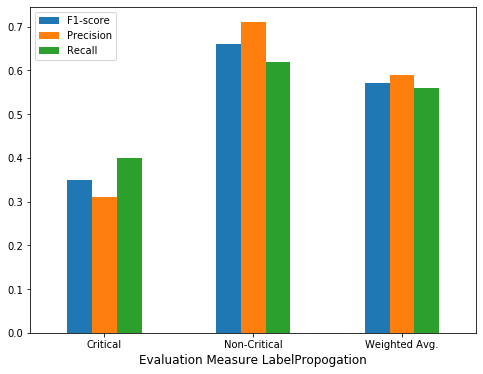

In [82]:
label_propogate_report = get_results('LabelPropogation', float)

/home/ali/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelSpreading from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


                  0.0          1.0  accuracy    macro avg  weighted avg
precision    0.300787     0.702276   0.58728     0.501532      0.582391
recall       0.288520     0.714469   0.58728     0.501495      0.587280
f1-score     0.294526     0.708320   0.58728     0.501423      0.584760
support    662.000000  1555.000000   0.58728  2217.000000   2217.000000


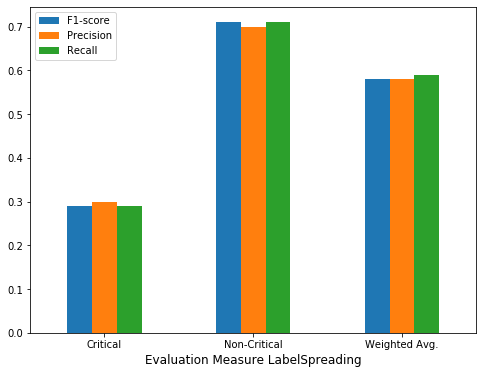

In [83]:
label_spread_report = get_results('LabelSpreading', float)

In [84]:
label_propogate_report = label_propogate_report.rename({'vals': 'Label Propogation'}, axis=1)
label_spread_report = label_spread_report.rename({0: 'Label Spreading'}, axis=1)

In [85]:
label_result = pd.concat([label_propogate_report, label_spread_report], axis=1)

In [86]:
label_result

Measures,F1-score,Precision,Recall,F1-score,Precision,Recall
Classes,,,,,,
Critical,0.35,0.31,0.40,0.29,0.30,0.29
Non-Critical,0.66,0.71,0.62,0.71,0.70,0.71
Weighted Avg.,0.57,0.59,0.56,0.58,0.58,0.59


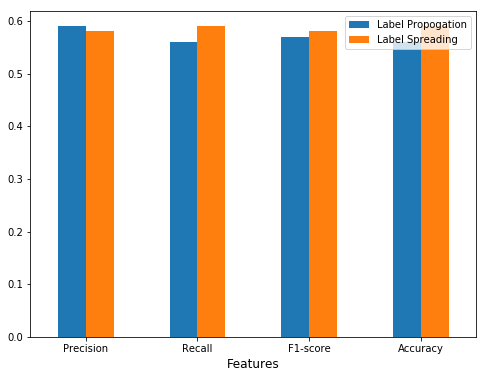

In [62]:
ax = label_result.plot(kind='bar', figsize=(8,6), rot=False)
plt.xlabel('Features', fontsize=12)
plt.savefig('{}_results.pdf'.format('Label_Propogate_Spread'), dpi=720)

In [5]:
def get_acc(classifier, data_type):
    dict_features = {}
    dict_acc = {}
    for features in [100, 500, 1000]:
        model = joblib.load('models/{}_{}_{}.pkl'.format(classifier, features, 3))
        x_tst = joblib.load('models/X_test_{}_{}_{}.pkl'.format(classifier, features, 3))
        y_tst = joblib.load('models/Y_test_{}_{}_{}.pkl'.format(classifier, features, 3))
        acc = accuracy_score(y_tst.astype(data_type), model.transduction_[:2217].astype(data_type))
        print features, acc

In [6]:
get_acc('LabelPropogation', float)

100 0.5904375281912494
500 0.5561569688768606
1000 0.5354082092918359


In [7]:
get_acc('LabelSpreading', float)

100 0.5944970681100586
500 0.5872801082543978
1000 0.5949481281010375
